In [16]:
# Setup & Imports
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # OpenCV for image loading/resizing
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from PIL import Image

# Render plots inline
%matplotlib inline

BASE_DIR = r"E:\brisc2025"
print("✅ BASE_DIR =", BASE_DIR)


✅ BASE_DIR = E:\brisc2025


In [2]:
# Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)

## BRISC2025 Folder Layout:
brisc2025/
  classification_task/
  segmentation_task/
  classification_task/
    test/
    train/
    test/
      glioma/
      meningioma/
      no_tumor/
      pituitary/
    train/
      glioma/
      meningioma/
      no_tumor/
      pituitary/
  segmentation_task/
    test/
    train/
    test/
      images/
      masks/
    train/
      images/
      masks/


In [3]:
# File Count Logic 
def count_patterns(patterns):
    return sum(len(glob.glob(p)) for p in patterns)

# Classification
splits = ["train", "test"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
cls_records = []
for sp in splits:
    total = 0
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        cnt = count_patterns([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': cnt})
        total += cnt
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': total})
df_cls = pd.DataFrame(cls_records)

# Segmentation
types_ = ["images", "masks"]
seg_records = []
for sp in splits:
    for tp in types_:
        pats = [
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.jpg"),
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.png")
        ]
        cnt = count_patterns(pats)
        seg_records.append({'Split': sp, 'Type': tp, 'Count': cnt})
df_seg = pd.DataFrame(seg_records)

# Display
print("### Classification Counts")
display(df_cls)
print("### Segmentation Counts")
display(df_seg)

### Classification Counts


,Split,Class,Count
0,train,glioma,1147
1,train,meningioma,1329
2,train,pituitary,1457
3,train,no_tumor,1067
4,train,Total,5000
5,test,glioma,254
6,test,meningioma,306
7,test,pituitary,300
8,test,no_tumor,140
9,test,Total,1000


### Segmentation Counts


,Split,Type,Count
0,train,images,3933
1,train,masks,3933
2,test,images,860
3,test,masks,860


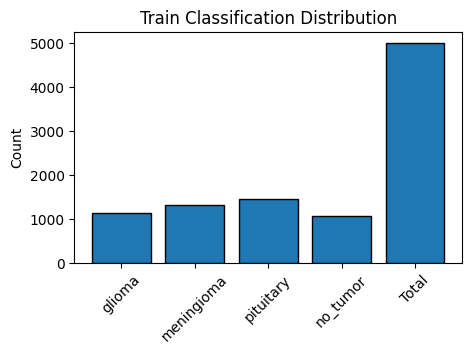

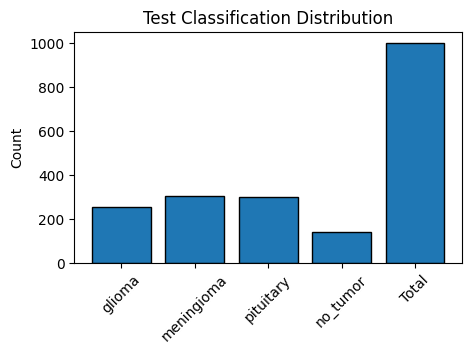

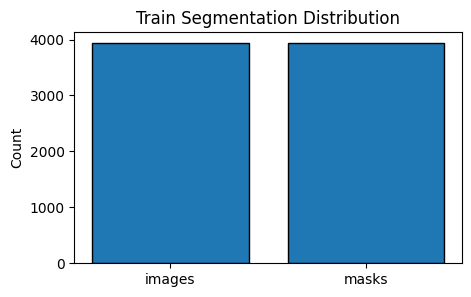

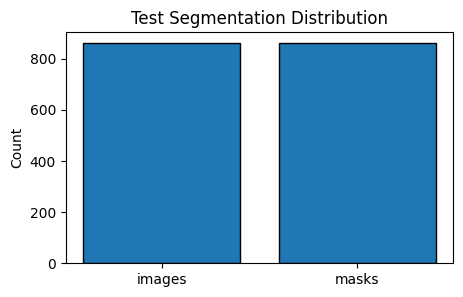

In [4]:
# Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

for sp in splits:
    sub = df_seg[df_seg.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Type, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Segmentation Distribution")
    plt.ylabel("Count")
    plt.show()

In [5]:
# Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))

### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

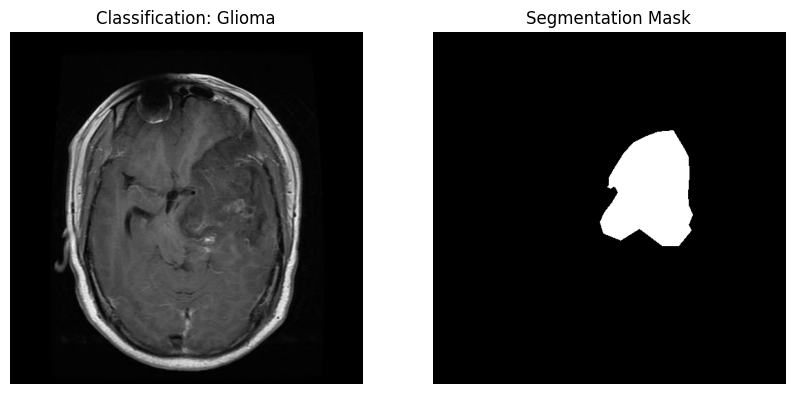

In [6]:
# Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
mask_path = first_file(os.path.join(BASE_DIR, "segmentation_task/train/masks"), ["png","jpg"])

img  = Image.open(img_path)
mask = Image.open(mask_path)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Segmentation Mask");    axes[1].axis("off")
plt.show()

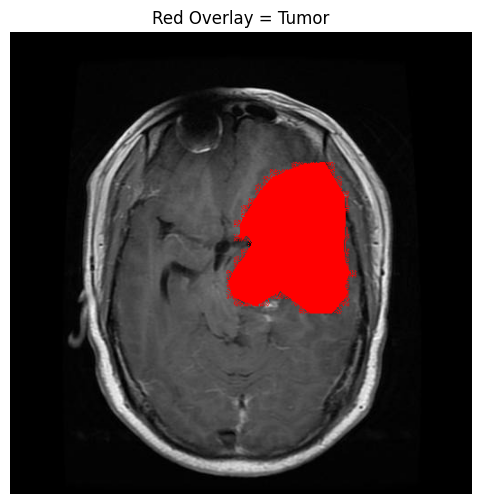

In [8]:
# Overlay
img_rgb  = np.array(img.convert("RGB"))
mask_arr = np.array(mask)

overlay = img_rgb.copy()
overlay[mask_arr>0] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(overlay); plt.title("Red Overlay = Tumor"); plt.axis("off")
plt.show()

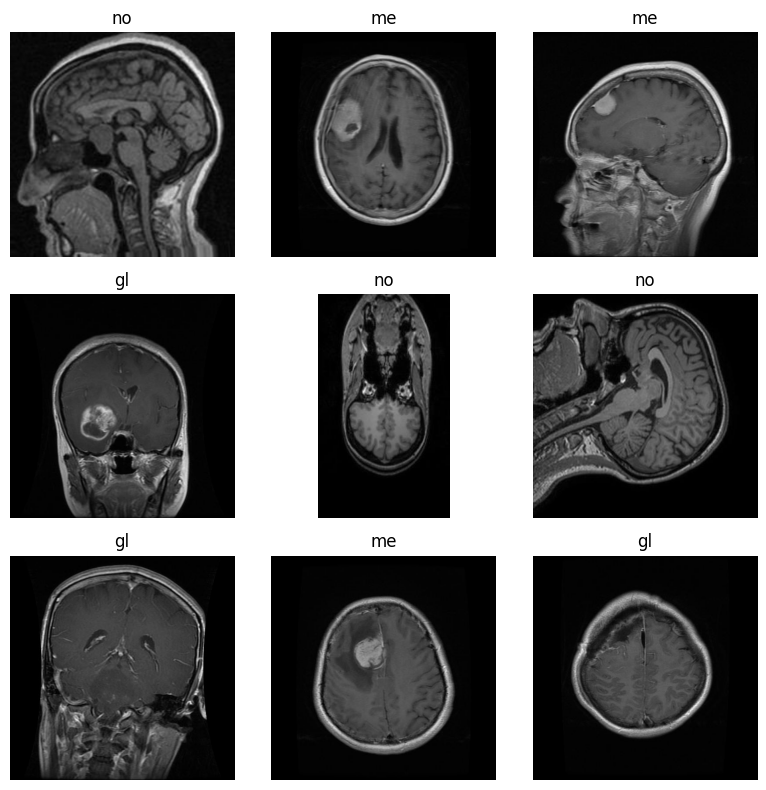

In [9]:
# Random Grid
samples = glob.glob(os.path.join(BASE_DIR, "classification_task/train/*/*.jpg"))
grid = np.random.choice(samples, 9, replace=False)

fig, axes = plt.subplots(3,3, figsize=(8,8))
axes = axes.flatten()
for ax, fp in zip(axes, grid):
    im = Image.open(fp)
    cls = os.path.basename(fp).split("_")[3]
    ax.imshow(im, cmap="gray")
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

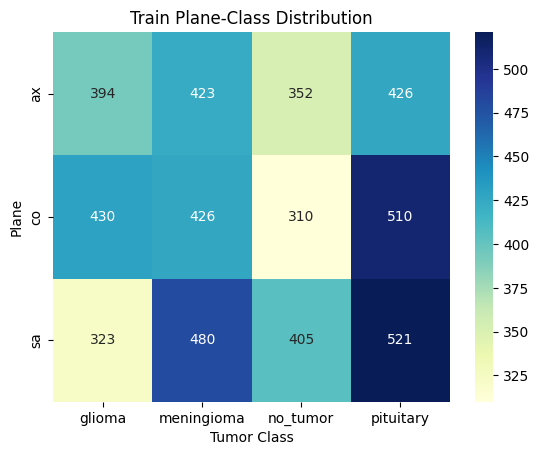

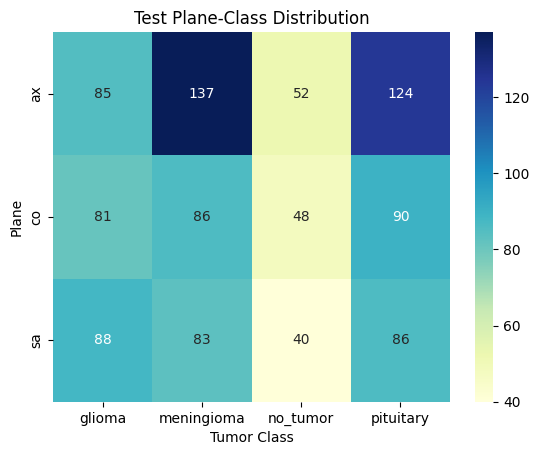

In [10]:
# Per-Plane Heatmaps

# Manually defined counts from your pivot table
plane_counts = {
    'train': {
        'glioma': [394, 430, 323],
        'meningioma': [423, 426, 480],
        'no_tumor': [352, 310, 405],
        'pituitary': [426, 510, 521]
    },
    'test': {
        'glioma': [85, 81, 88],
        'meningioma': [137, 86, 83],
        'no_tumor': [52, 48, 40],
        'pituitary': [124, 90, 86]
    }
}
planes = ['ax', 'co', 'sa']

def plot_plane_heatmap(split):
    df = pd.DataFrame(plane_counts[split], index=planes)
    sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'{split.capitalize()} Plane-Class Distribution')
    plt.xlabel('Tumor Class')
    plt.ylabel('Plane')
    plt.show()

plot_plane_heatmap('train')
plot_plane_heatmap('test')



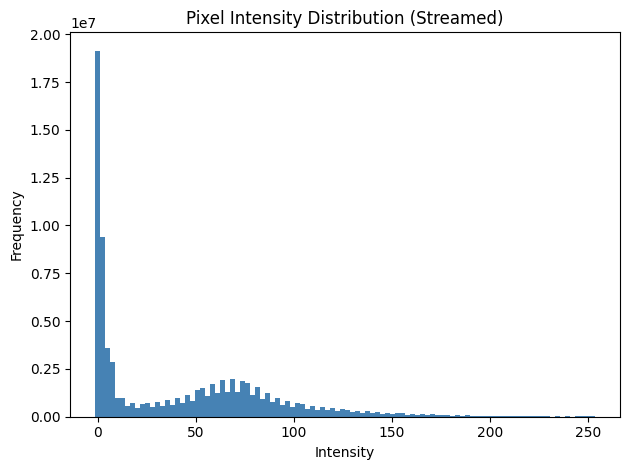

In [11]:
# Histograms

def collect_image_paths(base_dir, subset='train'):
    paths = []
    for cls in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
        cls_dir = os.path.join(base_dir, 'classification_task', subset, cls)
        for fname in os.listdir(cls_dir):
            if fname.endswith('.jpg') or fname.endswith('.png'):
                paths.append(os.path.join(cls_dir, fname))
    return paths

def plot_intensity_histogram_streamed(image_paths, resize_to=(128, 128), bins=100):
    hist_accum = np.zeros(bins)
    bin_edges = None

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            if resize_to:
                img = cv2.resize(img, resize_to)
            hist, edges = np.histogram(img, bins=bins, range=(0, 255))
            hist_accum += hist
            if bin_edges is None:
                bin_edges = edges

    plt.bar(bin_edges[:-1], hist_accum, width=(bin_edges[1] - bin_edges[0]), color='steelblue')
    plt.title('Pixel Intensity Distribution (Streamed)')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

image_paths = collect_image_paths(BASE_DIR, subset='train')
plot_intensity_histogram_streamed(image_paths, resize_to=(128, 128), bins=100)



In [13]:
# Checking Dimensions of all the images

from collections import Counter

def summarize_image_dimensions(image_paths):
    dim_counter = Counter()
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            dim_counter[img.shape] += 1
    return dim_counter
dimension_summary = summarize_image_dimensions(image_paths)

# Print summary
for dim, count in dimension_summary.items():
    print(f"Dimension {dim}: {count} images")

Dimension (512, 512): 4120 images
Dimension (237, 213): 2 images
Dimension (500, 455): 3 images
Dimension (270, 250): 1 images
Dimension (546, 472): 1 images
Dimension (427, 441): 1 images
Dimension (510, 485): 2 images
Dimension (605, 507): 1 images
Dimension (345, 338): 1 images
Dimension (554, 554): 2 images
Dimension (398, 369): 1 images
Dimension (650, 591): 1 images
Dimension (398, 351): 1 images
Dimension (377, 341): 1 images
Dimension (624, 491): 1 images
Dimension (358, 314): 1 images
Dimension (307, 257): 1 images
Dimension (223, 200): 2 images
Dimension (345, 300): 1 images
Dimension (340, 291): 1 images
Dimension (354, 318): 1 images
Dimension (341, 315): 1 images
Dimension (306, 278): 1 images
Dimension (442, 442): 6 images
Dimension (522, 513): 1 images
Dimension (401, 312): 1 images
Dimension (412, 300): 1 images
Dimension (251, 205): 1 images
Dimension (249, 204): 1 images
Dimension (342, 323): 1 images
Dimension (216, 216): 1 images
Dimension (372, 341): 1 images
Dimen

In [20]:
# Resize and saving 


def resize_and_save_images(src_base, dst_base, target_size=(128, 128)):
    for split in ['train', 'test']:
        for cls in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
            src_dir = os.path.join(src_base, 'classification_task', split, cls)
            dst_dir = os.path.join(dst_base, 'classification_task', split, cls)
            os.makedirs(dst_dir, exist_ok=True)

            for fname in os.listdir(src_dir):
                if fname.endswith('.jpg') or fname.endswith('.png'):
                    src_path = os.path.join(src_dir, fname)
                    dst_path = os.path.join(dst_dir, fname)

                    img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img_resized = cv2.resize(img, target_size)
                        cv2.imwrite(dst_path, img_resized)


def resize_segmentation_pairs(src_base, dst_base, target_size=(128, 128)):
    for split in ['train', 'test']:
        img_src_dir = os.path.join(src_base, 'segmentation_task', split, 'images')
        mask_src_dir = os.path.join(src_base, 'segmentation_task', split, 'masks')

        img_dst_dir = os.path.join(dst_base, 'segmentation_task', split, 'images')
        mask_dst_dir = os.path.join(dst_base, 'segmentation_task', split, 'masks')

        os.makedirs(img_dst_dir, exist_ok=True)
        os.makedirs(mask_dst_dir, exist_ok=True)

        # Build a map of mask files by base name
        mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_src_dir) if f.endswith('.png')}

        for img_fname in os.listdir(img_src_dir):
            if img_fname.endswith('.jpg'):
                base_name = os.path.splitext(img_fname)[0]
                mask_fname = mask_files.get(base_name)

                if mask_fname:
                    img_path = os.path.join(img_src_dir, img_fname)
                    mask_path = os.path.join(mask_src_dir, mask_fname)

                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None and mask is not None:
                        img_resized = cv2.resize(img, target_size)
                        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

                        cv2.imwrite(os.path.join(img_dst_dir, img_fname), img_resized)
                        cv2.imwrite(os.path.join(mask_dst_dir, mask_fname), mask_resized)
                else:
                    print(f"No matching mask for image: {img_fname}")
# Usage
SRC_DIR = r"E:\brisc2025"
DST_DIR = r"E:\brisc2025_resized_128"
resize_and_save_images(SRC_DIR, DST_DIR)
resize_segmentation_pairs(SRC_DIR, DST_DIR)

In [21]:
# Applying CLAHE and Zscore_Normalization

# CLAHE enhancement
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

# Z-score normalization
def zscore_normalize(img):
    img = img.astype('float32')
    mean, std = img.mean(), img.std()
    img = (img - mean) / std if std > 0 else img - mean
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    return img

# Full preprocessing pipeline
def preprocess_mri_image(path, size=(128, 128), normalize=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {path}")
    
    img = cv2.resize(img, size)
    img = apply_clahe(img)

    if normalize:
        img = zscore_normalize(img)

    return img

# Enhance classification images
def enhance_classification_images(resized_base_dir, output_base_dir, normalize=True):
    for split in ['train', 'test']:
        for cls in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
            src_dir = os.path.join(resized_base_dir, 'classification_task', split, cls)
            dst_dir = os.path.join(output_base_dir, 'classification_task', split, cls)
            os.makedirs(dst_dir, exist_ok=True)

            for fname in os.listdir(src_dir):
                if fname.lower().endswith(('.jpg', '.png')):
                    src_path = os.path.join(src_dir, fname)
                    dst_path = os.path.join(dst_dir, fname)

                    try:
                        enhanced_img = preprocess_mri_image(src_path, size=(128, 128), normalize=normalize)
                        cv2.imwrite(dst_path, enhanced_img)
                    except Exception as e:
                        print(f"Error processing {src_path}: {e}")

# Enhance segmentation images and copy masks
def enhance_segmentation_images(resized_base_dir, output_base_dir, normalize=True):
    for split in ['train', 'test']:
        img_src_dir = os.path.join(resized_base_dir, 'segmentation_task', split, 'images')
        mask_src_dir = os.path.join(resized_base_dir, 'segmentation_task', split, 'masks')

        img_dst_dir = os.path.join(output_base_dir, 'segmentation_task', split, 'images')
        mask_dst_dir = os.path.join(output_base_dir, 'segmentation_task', split, 'masks')

        os.makedirs(img_dst_dir, exist_ok=True)
        os.makedirs(mask_dst_dir, exist_ok=True)

        for fname in os.listdir(img_src_dir):
            if fname.lower().endswith(('.jpg', '.png')):
                src_path = os.path.join(img_src_dir, fname)
                dst_path = os.path.join(img_dst_dir, fname)

                try:
                    enhanced_img = preprocess_mri_image(src_path, size=(128, 128), normalize=normalize)
                    cv2.imwrite(dst_path, enhanced_img)
                except Exception as e:
                    print(f"Error processing {src_path}: {e}")

        # Copy masks without modification
        for fname in os.listdir(mask_src_dir):
            if fname.lower().endswith(('.png', '.jpg')):
                src_mask_path = os.path.join(mask_src_dir, fname)
                dst_mask_path = os.path.join(mask_dst_dir, fname)

                try:
                    mask = cv2.imread(src_mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        cv2.imwrite(dst_mask_path, mask)
                except Exception as e:
                    print(f"Error copying mask {src_mask_path}: {e}")


                    
# Run the enhancement
RESIZED_DIR = r"E:\brisc2025_resized_128"
ENHANCED_DIR = r"E:\brisc2025_enhanced_128"

enhance_classification_images(RESIZED_DIR, ENHANCED_DIR, normalize=True)
enhance_segmentation_images(RESIZED_DIR, ENHANCED_DIR, normalize=True)


In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=64):
        super(UNet, self).__init__()
        features = init_features

        self.enc1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self._block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = self._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, 2, 2)
        self.dec4 = self._block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, 2, 2)
        self.dec3 = self._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, 2, 2)
        self.dec2 = self._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, 2, 2)
        self.dec1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )


In [ ]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, os.path.splitext(self.image_files[idx])[0] + '.png')

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, self.size)
        mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32)
        mean, std = img.mean(), img.std()
        img = (img - mean) / std if std > 0 else img - mean
        img = np.expand_dims(img, axis=0)  # [1, H, W]
        mask = (mask > 0).astype(np.float32)  # binary mask
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(img), torch.tensor(mask)


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

def train_unet(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


In [ ]:
train_dataset = SegmentationDataset(
    image_dir=r"E:\brisc2025_enhanced_128\segmentation_task\train\images",
    mask_dir=r"E:\brisc2025_enhanced_128\segmentation_task\train\masks"
)

test_dataset = SegmentationDataset(
    image_dir=r"E:\brisc2025_enhanced_128\segmentation_task\test\images",
    mask_dir=r"E:\brisc2025_enhanced_128\segmentation_task\test\masks"
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

model = UNet(in_channels=1, out_channels=1)
train_unet(model, train_loader, test_loader, epochs=10, lr=1e-3)


In [ ]:
model = UNet(in_channels=1, out_channels=1)
input_tensor = torch.randn(1, 1, 128, 128)  # Batch size 1, grayscale
output = model(input_tensor)
print("Output shape:", output.shape)  # Should be [1, 1, 128, 128]
